En este codigo queremos generar un grafico muy similar al que hicimos del staircase inicial pero con los datos del primer experimento.

Para eso primero copio todo el codigo que regenera los datos de ese experimento

In [5]:
#imnportamos cosas y giladas
%matplotlib inline
from os import listdir
from os.path import isfile, join



# Primero queremos listas todos los archivos
onlyfiles = [f for f in listdir('./../ProcesamientoPostDependenciaAngulo/data/') if isfile(join('./../ProcesamientoPostDependenciaAngulo/data/', f))]

# Queremos transformar cada archivo en un dataframe con entradas para ver entradas repetidas

import pandas as pd
import json

#Creamos la lista vacia de envios

sesiones = []
levels = []
convergencias = []

#Buscamos leer todas las entradas
for file in onlyfiles:
    with open('./../ProcesamientoPostDependenciaAngulo/data/'+file) as data_file:
            db = json.load(data_file)
    for envio in db['Envio']:
        if envio['tipoDeEnvio'] == 'NEWSESION':
            sesiones = sesiones + [envio]
        elif envio['tipoDeEnvio'] == 'NEWLEVEL':
            levels = levels + [envio]
        elif envio['tipoDeEnvio'] == 'CONVERGENCIA':
            convergencias = convergencias + [envio]
        elif envio['tipoDeEnvio']:
            print (envio['tipoDeEnvio'])
        else: 
            print (envio)

# Filtramos por envios unicos
envioshechos = []

sesionesUnique = []
for envio in sesiones:
    if not envio['instance'] in envioshechos:
        sesionesUnique = sesionesUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

levelsUnique = []
for envio in levels:
    if not envio['instance'] in envioshechos:
        levelsUnique = levelsUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

convergenciasUnique = []
for envio in convergencias:
    if not envio['instance'] in envioshechos:
        convergenciasUnique = convergenciasUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

        
        
        
# Acabo de descubrir que los envio de Pierina nunca se hicieron bien. Copie en la carpeta dataCruda los envios que nunca se hicieron y recupere de la compu
onlyfiles2 = [f for f in listdir('./../ProcesamientoPostDependenciaAngulo/DataCruda/') if isfile(join('./../ProcesamientoPostDependenciaAngulo/DataCruda/', f))]
import os

for file in onlyfiles2:
    name, ext = os.path.splitext( os.path.basename(file))
    with open('./../ProcesamientoPostDependenciaAngulo/DataCruda/'+file) as data_file:
            data = json.load(data_file)
    if not int(name) in envioshechos:
        if ext == '.NEWLEVEL':
            levelsUnique = levelsUnique + [data]
        if ext == '.NEWSESION':
            sesionesUnique = sesionesUnique + [data]
        if ext == '.CONVERGENCIA':
            convergenciasUnique = convergenciasUnique + [data]    

            
            
            
usuarios = {1459443370368:'Agustin', 1460500029182:'Chalukian', 1460568434768:'Chechu',1459459628908:'Euge',
           1459455977180:'Flor', 1459450579229:'Guido', 1460384100961:'Jule', 1459368818910:'Lungo',
           1460497107413:'Marta', 1459358889070:'Martina', 1460645753225:'Pierina', 1459350343607:'Roli'}



# Queremos aplicar un filtro donde, primero se filtren todoas las entradas que tengan una sesion para usuarios validos
sesionesFiltradas = [item for item in sesionesUnique if item['userId'] in usuarios.keys()]
# Por alguna razon se ve que un usuario hizo dos sesiones. 

# Aplicamos un filtro que selecciones los niveles y las convergencias que hayan sucedido en alguna de las sesiones filtradas
sesionesInstances = [item['sessionInstance'] for item in sesionesFiltradas]

levelsFiltrados = [item for item in levelsUnique if item['session']['sessionInstance'] in sesionesInstances]
convergenciasFiltradas = [item for item in convergenciasUnique if item['expLog']['session']['sessionInstance'] in sesionesInstances]






# Pasamos el formato a dataframe
sesionesPanda = pd.DataFrame(sesionesFiltradas)
levelsPanda = pd.DataFrame(levelsFiltrados)
convergenciasPanda = pd.DataFrame(convergenciasFiltradas)





### Retocamos un poco la info para que sea mas manejable (basicamente hay que extraer cada cosa de adentro de los dict
cpd = convergenciasPanda

for key in cpd.iloc[0]['expLog']:
    cpd[key] = cpd['expLog'].map(lambda x: x[key])
cpd = cpd.drop('expLog',1)
for key in cpd.iloc[0]['session']:
    cpd[key] = cpd['session'].map(lambda x: x[key])
cpd = cpd.drop('session',1)

for key in cpd.iloc[0]['dinamica']:
    cpd[key] = cpd['dinamica'].map(lambda x: x[key])
cpd = cpd.drop('dinamica',1)
cpd['ultimoTrial'] = cpd['historial'].map(lambda x: x[-1] if (len (x) > 1) else None)
for key in cpd.iloc[0]['ultimoTrial']:
    cpd[key] = cpd['ultimoTrial'].map(lambda x: x[key] if (x) else None)
cpd = cpd.drop('ultimoTrial',1)

for key in cpd.iloc[0]['estimulo']: # Hay que tener cuidado que no todos los dict son iguales. Este es un dict de paralelismio
    cpd[key] = cpd['estimulo'].map(lambda x: None if not x else x[key] if key in x else None)
for key in cpd.iloc[7]['estimulo']: # Hay que tener cuidado que no todos los dict son iguales. Este es un dict de angulos
    cpd[key] = cpd['estimulo'].map(lambda x: None if not x else x[key] if key in x else None)
cpd = cpd.drop('estimulo',1)

#Revisando los archivos fuente dentro del jar de la versión 31 (que es la que se uso en el experimento) chequie que el valor reportado de los estimulos es el semi angulo para el caso de las serie de paralelismo.
#En el caso de los angulos, es el angulo formado, que ya procesa el tema dela desviacion.
cpd['desviacionDoble'] = cpd['desviacion'] * 2

# Sacamos niveles espureos
cpd = cpd[cpd['expName']!='UmbralAngulosTutorial']
cpd = cpd[cpd['expName']!='UmbralParalelismoTutorial']

# Sacamos los registros de niveles que se marcaron en tiempo de ejecusion como no temrinados
cpd = cpd[cpd['convergenciaFinalizada']]




Ahora si, en cpd hay una lista de todas las series de los usuarios que realizaron el experimento

In [25]:
from IPython.display import display

datos = []
for row in cpd.iterrows():
    row = row[1]
    data = {}
    data['Experimento'] = row['expName']
    data['Usuario'] = row['userId']
    data['Convergio'] = row['convergenciaFinalizada']
    data['referencia'] = row['referencia']
    data['aciertos'] = [x['acertado'] for x in row['historial']]
    data['niveles'] = [x['estimulo']['nivelSenal'] for x in row['historial']]
    datos = datos + [data]
    
DataLinda = pd.DataFrame(datos)

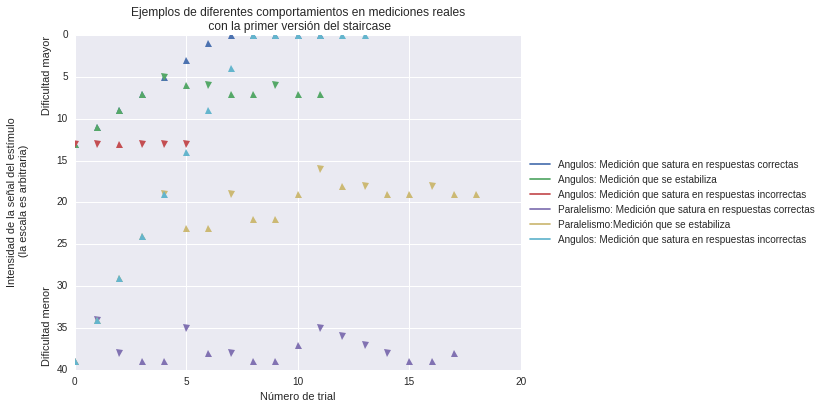

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(8,6))

plt.axis([0, 20, 40, 0])

N = 90
#indices = [x+N for x in [0,1,2,3,4,5,6,7,8,9]]
indices = [6,94,34,15,27,37]
#lables = [str(x) for x in indices]
labels = ['Angulos: Medición que satura en respuestas correctas','Angulos: Medición que se estabiliza',
      'Angulos: Medición que satura en respuestas incorrectas','Paralelismo: Medición que satura en respuestas correctas',
      'Paralelismo:Medición que se estabiliza','Angulos: Medición que satura en respuestas incorrectas']
colors=sns.color_palette()*2

for i,ind in enumerate(indices):
    # ax.plot(DataLinda['niveles'].iloc[ind], label=lables[i], color=colors[i])
    #ax.plot([], label=DataLinda['Experimento'].iloc[ind]+' orientación: '+str(DataLinda['referencia'].iloc[ind]), color=colors[i])
    ax.plot([], label=labels[i], color=colors[i])
    # Dibujamos los triangulos hacia abajo
    x = [indice for indice in range(len(DataLinda['niveles'].iloc[ind])) if DataLinda['aciertos'].iloc[ind][indice]]
    y = [DataLinda['niveles'].iloc[ind][indice] for indice in range(len(DataLinda['niveles'].iloc[ind])) if DataLinda['aciertos'].iloc[ind][indice]]
    ax.plot(x, y, '^', color=colors[i])
    # Dibujamos los triangulos hacia arriba
    x = [indice for indice in range(len(DataLinda['niveles'].iloc[ind])) if not DataLinda['aciertos'].iloc[ind][indice]]
    y = [DataLinda['niveles'].iloc[ind][indice] for indice in range(len(DataLinda['niveles'].iloc[ind])) if not DataLinda['aciertos'].iloc[ind][indice]]
    ax.plot(x, y, 'v', color=colors[i])
    
    
plt.title('Ejemplos de diferentes comportamientos en mediciones reales \n con la segunda versión del staircase')
plt.xlabel('Número de trial')
plt.ylabel('Intensidad de la señal del estímulo \n (la escala es arbitraria) \n \n Dificultad menor                                                         Dificultad mayor')

#plt.ylabel('Nivel de la señal (escala lineal arbitraria)')
#plt.text(-4,54,'Mayor dificultad',rotation=90, fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('./../Images/StairCase2.png', bbox_inches='tight', dpi=600)


# Uno satura
# Seis satura!
# 8, 15, (21 o 27) mala, 34 mala (31 o 37) buena

In [38]:
len(colors)

6

In [24]:
DataLinda

,Convergio,Experimento,Usuario,aciertos,niveles,referencia
0,True,UmbralParalelismoPiloto,1459350343607,"[False, True, True, True, False, True, True, T...","[39, 39, 39, 34, 29, 33, 33, 29, 25, 21, 17, 1...",0
1,True,UmbralParalelismoPiloto,1459350343607,"[True, True, True, True, True, True, False, Tr...","[39, 34, 29, 24, 19, 14, 9, 13, 13, 9, 5, 1, 4...",0
2,True,UmbralParalelismoPiloto,1459350343607,"[True, False, True, True, True, True, True, Fa...","[39, 34, 38, 38, 34, 30, 26, 22, 25, 28, 31, 3...",30
3,True,UmbralParalelismoPiloto,1459350343607,"[True, True, True, False, False, True, True, T...","[39, 34, 29, 24, 28, 32, 32, 28, 24, 20, 23, 2...",30
4,True,UmbralParalelismoPiloto,1459350343607,"[True, True, True, True, True, True, False, Tr...","[39, 34, 29, 24, 19, 14, 9, 13, 13, 9, 5, 1, 0...",90
5,True,UmbralParalelismoPiloto,1459350343607,"[True, True, True, True, True, True, True, Tru...","[39, 34, 29, 24, 19, 14, 9, 4, 0, 4, 4, 0, 0, ...",90
6,True,UmbralAngulosPiloto,1459350343607,"[True, True, True, True, True, True, True, Tru...","[13, 11, 9, 7, 5, 3, 1, 0, 0, 0, 0, 0]",0
7,True,UmbralAngulosPiloto,1459350343607,"[True, True, True, True, True, True, True, Tru...","[13, 11, 9, 7, 5, 3, 1, 0, 0, 0, 0, 0]",0
8,True,UmbralAngulosPiloto,1459350343607,"[True, True, True, True, True, True, False, Tr...","[18, 16, 14, 12, 10, 8, 6, 7, 7, 6, 5, 4, 3, 2...",30
9,True,UmbralAngulosPiloto,1459350343607,"[True, True, True, True, True, True, True, Fal...","[18, 16, 14, 12, 10, 8, 6, 4, 5, 6, 7, 8, 8, 7...",30
